# Depthwise Convolutional Autoeconder

This code trains a simple autoencoder neural network using convolutional
layers. However, differently from the default convolutional layers, the 
depthwise convolutional layer acts on each input channel separately. The 
contraction and expansion of the implemented neural network used only 
convolutional layers. Therefore, it does not rely on maxpooling or upsampling
layers. Instead, it was used strides to control the contraction and expansion
of the neural network. Also, in the decoder part it was used a decovolutional
process.

For the latent space it was used a fully connected layer with an additional
fully connected layer in sequence, to connect the latent space with the
decoder convolutional layer.

The neural network architecture with the activation function is stated below.

## Prelimiary steps

In [ ]:
# Optional cell if the current path already has the data and the file utils.py
%cd .. 
%cd .. 

In [2]:
# Import modules
import h5py
import keras.layers as layers
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Model

from utils import plot_red_comp, slicer, split


# Path to store training data
save_path = "./tests/jupyter-notebooks/models/train_ae_depth_{}"

Using TensorFlow backend.


###  Data manipulation

In [3]:
# Selecting data
dt_fl = "nn_data.h5"
dt_dst = "scaled_data"

# The percentage for the test is implicit
n_train = 0.8
n_valid = 0.1

# Select the variable to train
# 0: Temperature - 1: Pressure - 2: Velocity - None: all
var = None

Load the selected data and then split it.

In [4]:
# Open data file
f = h5py.File(dt_fl, "r")
dt = f[dt_dst]

# Split data file
idxs = split(dt.shape[0], n_train, n_valid)
slc_trn, slc_vld, slc_tst = slicer(dt.shape, idxs, var=var)
# Slice data
if var:
    x_train = dt[slc_trn][:, :, :, np.newaxis]
    x_val = dt[slc_vld][:, :, :, np.newaxis]
else:
    x_train = dt[slc_trn]
    x_val = dt[slc_vld]

# Convert the var into a slice
if var:
    slc = slice(var, var + 1)
else:
    slc = slice(var)

### Autoencoder settings

In [5]:
# Activation function
act = "tanh"  # Convolutional layers activation function
act_lt = "tanh"  # Latent space layers activation function
# Depth multiplier of each layer
mult = [3, 3, 3]
# Number of filters of the decoding layers
flt = [3, 9, 27]
# Filter size
flt_size = 5
# Strides of each layer
strd = [2, 2, 5]
# Latent space size
lt_sz = 90

# Training settings
opt = "adam"  # Optimizer
loss = "mse"
epochs = 60
batch_size = 32

### Build autoencoder

In [6]:
# Build the autoencoder neural network
tf.keras.backend.clear_session()
flt_tp = (flt_size, flt_size)
conv_kwargs = dict(activation=act, padding="same")
# Encoder
inputs = layers.Input(shape=x_train.shape[1:])
e = layers.DepthwiseConv2D(
    flt_tp, depth_multiplier=mult[0], strides=strd[0], **conv_kwargs
)(inputs)
e = layers.DepthwiseConv2D(
    flt_tp, depth_multiplier=mult[1], strides=strd[1], **conv_kwargs
)(e)
e = layers.DepthwiseConv2D(
    flt_tp, depth_multiplier=mult[2], strides=strd[2], **conv_kwargs
)(e)

# Latent space
l = layers.Flatten()(e)
l = layers.Dense(lt_sz, activation=act_lt)(l)

# Latent to decoder
dn_flt = flt[-1]
d_shp = (x_train.shape[1:-1] / np.prod(strd)).astype(int)
d_sz = np.prod(d_shp) * dn_flt
d = layers.Dense(d_sz, activation=act_lt)(l)
d = layers.Reshape(np.hstack((d_shp, dn_flt)))(d)
# Decoder
d = layers.Conv2DTranspose(flt[-1], flt_tp, strides=strd[-1], **conv_kwargs)(d)
d = layers.Conv2DTranspose(flt[-2], flt_tp, strides=strd[-2], **conv_kwargs)(d)
d = layers.Conv2DTranspose(flt[-3], flt_tp, strides=strd[-3], **conv_kwargs)(d)
decoded = layers.Conv2DTranspose(
    x_train.shape[-1], flt_tp, activation="linear", padding="same"
)(d)

# Mount the autoencoder
ae = Model(inputs, decoded, name="Convolutional Autoencoder")

In [7]:
# Show the architecture
ae.summary()

Model: "Convolutional Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 100, 3)       0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 100, 50, 9)        234       
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 50, 25, 27)        702       
_________________________________________________________________
depthwise_conv2d_3 (Depthwis (None, 10, 5, 81)         2106      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4050)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                364590    
_________________________________________________________________
dense_2 (Dense)              (None, 1350)

## Callbacks
Early stopping to stop training when the validation loss start to increase
The patience term is a number of epochs to wait before stop. Also, the
'restore_best_weights' is used to restore the best model against the
validation dataset. It is necessary as not always the best model against
the validation dataset is the last neural network weights.

In [8]:
# Callbacks
monitor = "val_loss"
patience = int(epochs * 0.3)
es = EarlyStopping(
    monitor=monitor, mode="min", patience=patience, restore_best_weights=True
)

### Training

In [10]:
# Compile and train
ae.compile(optimizer=opt, loss=loss)
hist = ae.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=[es],
)

Train on 1133 samples, validate on 141 samples
Epoch 1/60
1133/1133 [==============================] - 4s 3ms/step - loss: 0.8458 - val_loss: 0.7152
Epoch 2/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.6008 - val_loss: 0.5050
Epoch 3/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.4366 - val_loss: 0.4333
Epoch 4/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.3878 - val_loss: 0.4030
Epoch 5/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.3683 - val_loss: 0.3882
Epoch 6/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.3575 - val_loss: 0.3801
Epoch 7/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.3513 - val_loss: 0.3758
Epoch 8/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.3484 - val_loss: 0.3733
Epoch 9/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.3447 - val_loss: 0.3693
Epoch 10/60
1133/1133 [============

### Save trained model

In [12]:
# Save the model
ae.save(save_path.format("model.h5"))

# Store the test dataset
if var:
    x_tst = dt[slc_tst][:, :, :, np.newaxis]
else:
    x_tst = dt[slc_tst]
np.save(save_path.format("test.npy"), x_tst)

### Training process

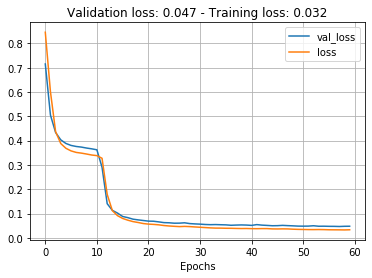

In [13]:
# Convert the history to a Pandas dataframe
hist_df = pd.DataFrame(hist.history)
hist_df.index.name = "Epochs"
# Save the training history
hist_df.to_hdf(save_path.format("hist.h5"), 'his')

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*hist_df.min())
hist_df.plot(grid=True, title=tit)

### Evaluate the trained model

In [14]:
# Test the trained neural network against the test dataset
if var:
    x_test = dt[slc_tst][:, :, :, np.newaxis]
else:
    x_test = dt[slc_tst]
loss = ae.evaluate(x_test, x_test)
print("Test dataset loss: {:.3f}".format(loss))

global_loss = ae.evaluate(dt[:, :, :, slc], dt[:, :, :, slc])
print("Entire dataset loss: {:.3f}".format(global_loss))

141/141 [==============================] - 0s 946us/step
Test dataset loss: 0.047
1415/1415 [==============================] - 1s 829us/step
Entire dataset loss: 0.035


In [15]:
# Comparing the input and output of the autoencoder neural network
data_index = 634

# Slice the data
dt_in = dt[data_index, :, :, slc]
# Get the neural network output
dt_out = ae.predict(dt_in[np.newaxis])
# Plot
alg = "Depthwise conv. autoencoder"

Plot temperature distribution

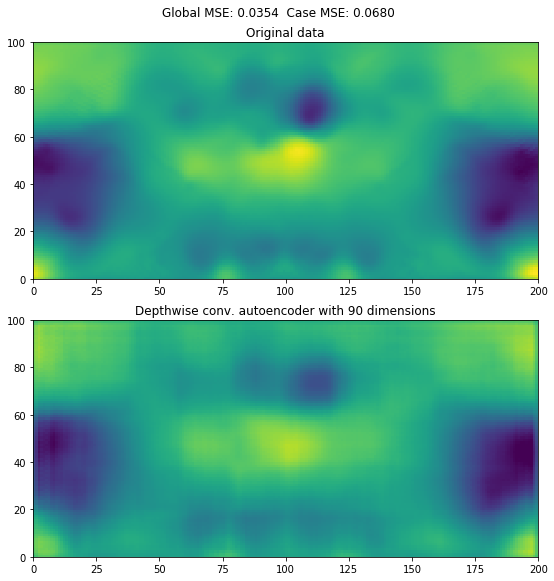

In [16]:
var_plt = 0
plot_red_comp(dt_in, dt_out[0], var_plt, lt_sz, global_loss, alg)

Plot pressure distribution

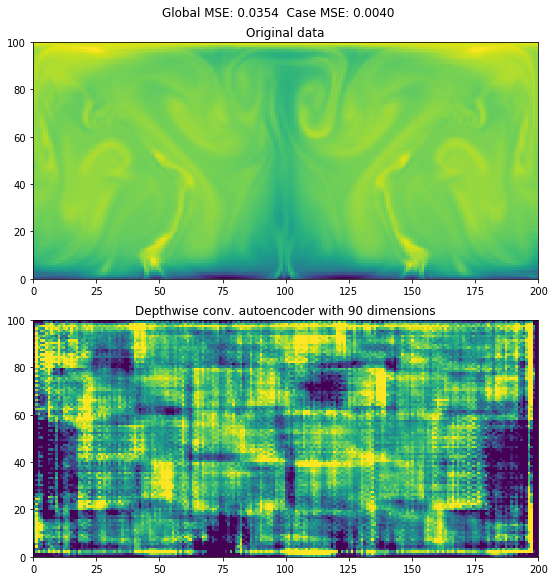

In [17]:
var_plt = 1
plot_red_comp(dt_in, dt_out[0], var_plt, lt_sz, global_loss, alg)

Plot velocity distribution

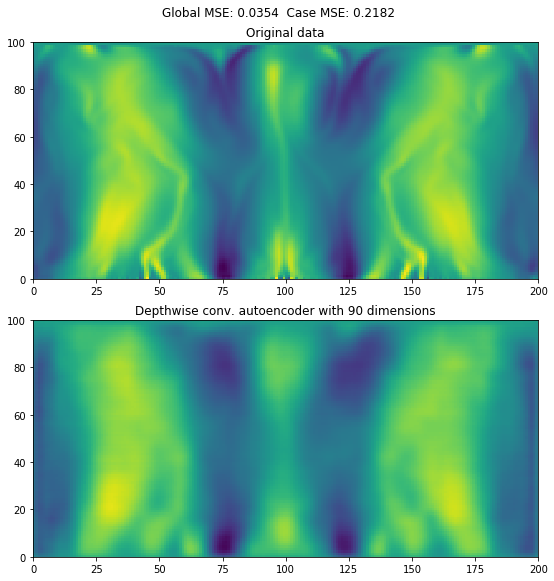

In [18]:
var_plt = 2
plot_red_comp(dt_in, dt_out[0], var_plt, lt_sz, global_loss, alg)